<a href="https://colab.research.google.com/github/danyarmarkin/llm-review-classification/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачиваем датасеты

In [1]:
!git clone https://github.com/danyarmarkin/llm-review-classification.git

Cloning into 'llm-review-classification'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 4), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 398.06 KiB | 12.06 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
# Импорт всех необходимых библиотек
!pip install transformers datasets accelerate peft bitsandbytes scikit-learn pandas numpy torch sentencepiece

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline, BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, classification_report
import re
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 19.7 MB/s eta 0:00:00


In [3]:
# Загрузка данных
train_df = pd.read_csv('/content/llm-review-classification/task/train.csv')
test_df = pd.read_csv('/content/llm-review-classification/task/test.csv')

# Загрузка категорий
with open('/content/llm-review-classification/task/categories.txt', 'r', encoding='utf-8') as f:
    categories = [line.strip() for line in f.readlines()]

# Добавляем категорию "нет товара"
if "нет товара" not in categories:
    categories.append("нет товара")

print(f"Всего категорий: {len(categories)}")
print(f"Категории: {categories}")
print(f"Размер тренировочных данных: {len(train_df)}")
print(f"Размер тестовых данных: {len(test_df)}")

Всего категорий: 9
Категории: ['бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль', 'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара']
Размер тренировочных данных: 1818
Размер тестовых данных: 7276


In [4]:
# Инициализация модели для разметки (используем 4-битное квантование для экономии памяти)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

model_name = "Qwen/Qwen2-7B-Instruct"  # Можно заменить на другую подходящую модель

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
# Функция для создания промпта
def create_prompt(text, categories, examples=None):
    prompt = f"""<|system|>
Ты — ассистент для точной классификации отзывов с маркетплейса. Твоя задача — определить категорию товара, к которому относится отзыв.

**Инструкции:**
1. Внимательно проанализируй текст отзыва.
2. Если отзыв НЕ о конкретном товаре (жалоба на доставку, службу поддержки, упаковку, скидки и т.д.) — ответь "нет товара".
3. Если отзыв о товаре, определи его категорию ТОЛЬКО из списка: {categories}.
4. Обращай особое внимание на контекст. Упоминание проблемы ("брак", "косяки") не всегда означает категорию.
5. Определи основной товар, о котором идет речь.

**Примеры правильной классификации:**
Отзыв: "Куртка отличная, но размер маловат. Пришлось обменять." -> Категория: Одежда
Отзыв: "Доставили на день позже обещанного, но товар целый." -> Категория: нет товара
Отзыв: "Книга интересная, но в мягком переплете, быстро порвалась." -> Категория: Книги
Отзыв: "Игрушка сломалась через день, очень расстроен." -> Категория: Товары для детей

**Отзыв для анализа:**
"{text}"

<|assistant|>
Категория:"""
    return prompt

# Функция для получения категории от модели
def get_category(text, max_new_tokens=5):
    prompt = create_prompt(text, categories)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    category_line = response.lower().split("категория:")[-1]
    predicted_category = "нет товара"
    for cat in categories:
      if cat in category_line:
        predicted_category = cat
        break

    return predicted_category

# Разметка части данных (возьмем 2000 примеров для обучения)
# sample_size = 20
train_sample = train_df.copy()

print("Начинаем автоматическую разметку данных...")
labeled_data = []
for i, row in tqdm(train_sample.iterrows(), total=len(train_sample)):
    try:
        category = get_category(row['text'])
        # print(category)
        labeled_data.append({'text': row['text'], 'category': category})
    except Exception as e:
        print(f"Ошибка при обработке текста {i}: {e}")
        continue

# Создаем DataFrame с размеченными данными
labeled_df = pd.DataFrame(labeled_data)

# Фильтруем некорректные категории
valid_categories = set(categories)
labeled_df = labeled_df[labeled_df['category'].isin(valid_categories)]

labeled_df.to_csv("labaled_dataset.csv")

print(f"Успешно размечено {len(labeled_df)} примеров")
print("Распределение категорий:")
print(labeled_df['category'].value_counts())

Начинаем автоматическую разметку данных...


  0%|          | 0/1818 [00:00<?, ?it/s]

Успешно размечено 1818 примеров
Распределение категорий:
category
одежда              1133
нет товара           415
текстиль             214
обувь                 25
электроника           13
товары для детей      13
бытовая техника        3
посуда                 2
Name: count, dtype: int64


In [14]:
labeled_df = pd.read_csv('labaled_dataset.csv')

In [11]:
# Функция для генерации синтетических отзывов
def generate_synthetic_reviews(category, n_samples, existing_texts=None):
    # Общий промпт для остальных категорий
    prompt_template = f"""<|system|>
Сгенерируй {n_samples} реалистичных отзывов на товары категории "{category}".

**Требования:**
1. Отзывы должны быть максимально естественными и разнообразными
2. Используй разговорный язык с естественными опечатками и сокращениями
3. Разный тон: негативные, восторженные, нейтральные, разочарованные, но конструктивные
4. Упоминай конкретные особенности товаров этой категории
5. Длина: от 1 до 3 предложений
6. Включай как оценку товара, так и личный опыт использования

**Пример хорошего отзыва:**
"Покупкой очень доволен, особенно ценой. Но качество, возможно, можно было бы улучшить. Рекомендую!"

<|assistant|>
Синтетические отзывы для категории "{category}":
1. """
    try:
        inputs = tokenizer(prompt_template, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2500,
                temperature=0.85,  # Более высокая температура для разнообразия
                do_sample=True,
                top_p=0.9,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Улучшенный парсинг ответа
        if "Синтетические отзывы" in response:
            reviews_text = response.split("Синтетические отзывы")[-1]
        else:
            reviews_text = response

        # Извлекаем отзывы по нумерации
        reviews = []
        lines = reviews_text.split('\n')

        for line in lines:
            line = line.strip()
            # Ищем строки, начинающиеся с цифры и точки
            if re.match(r'^\d+\.', line):
                review_text = re.sub(r'^\d+\.\s*', '', line).replace("\"", "")
                if len(review_text) > 15:
                    reviews.append(review_text)
            # Или просто качественные отзывы без нумерации
            elif len(line) > 30 and ':' not in line and not line.isdigit():
                reviews.append(line)

        return reviews[:n_samples]

    except Exception as e:
        print(f"Ошибка генерации для {category}: {e}")
        return []


# Функция для проверки и фильтрации сгенерированных отзывов
def validate_generated_review(review, target_category, validator_model, validator_tokenizer):
    """Проверяет, действительно ли сгенерированный отзыв относится к целевой категории"""
    validation_prompt = f"""<|system|>
Быстро проверь, относится ли этот отзыв к категории "{target_category}".
Отзыв: "{review}"
Ответь только "да" или "нет".

<|assistant|>"""

    try:
        inputs = validator_tokenizer(validation_prompt, return_tensors="pt").to(validator_model.device)

        with torch.no_grad():
            outputs = validator_model.generate(
                **inputs,
                max_new_tokens=3,
                temperature=0.1,
                do_sample=False
            )

        response = validator_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return "да" in response.lower()

    except Exception as e:
        print(f"Ошибка валидации: {e}")
        return False

# Основной пайплайн генерации синтетических данных
print("Начинаем генерацию синтетических отзывов...")

# Анализируем текущее распределение
category_counts = labeled_df['category'].value_counts()
print("Текущее распределение категорий:")
print(category_counts)

# Определяем, сколько примеров нужно сгенерировать для каждой категории
target_samples = 150
synthetic_data = []

for category in tqdm(categories):
    current_count = category_counts.get(category, 0)
    needed_samples = max(0, target_samples - current_count)

    if needed_samples > 0:
        print(f"Генерируем {needed_samples} примеров для категории '{category}'...")

        # Генерируем с запасом (не все пройдут валидацию)
        batch_size = 8
        valid_reviews = []
        for _ in tqdm(range((needed_samples + batch_size - 1) // batch_size)):
          generated_reviews = generate_synthetic_reviews(category, batch_size)

          # Валидируем сгенерированные отзывы

          for review in generated_reviews:
              if validate_generated_review(review, category, model, tokenizer):
                  valid_reviews.append(review)

        # Добавляем валидные отзывы
        for review in valid_reviews[:needed_samples]:
          synthetic_data.append({
              'text': review,
              'category': category
          })

        print(f"Добавлено {len(valid_reviews[:needed_samples])} синтетических отзывов для '{category}'")

synthetic_df = pd.DataFrame(synthetic_data)
print(f"Всего сгенерировано {len(synthetic_df)} синтетических отзывов")
synthetic_df.to_csv('enriched_training_data.csv', index=False, encoding='utf-8')
print("Обогащенный датасет сохранен в 'enriched_training_data.csv'")

Начинаем генерацию синтетических отзывов...
Текущее распределение категорий:
category
одежда              1133
нет товара           415
текстиль             214
обувь                 25
электроника           13
товары для детей      13
бытовая техника        3
посуда                 2
Name: count, dtype: int64


  0%|          | 0/9 [00:00<?, ?it/s]

Генерируем 147 примеров для категории 'бытовая техника'...


  0%|          | 0/19 [00:00<?, ?it/s]

Добавлено 147 синтетических отзывов для 'бытовая техника'
Генерируем 125 примеров для категории 'обувь'...


  0%|          | 0/16 [00:00<?, ?it/s]

Добавлено 125 синтетических отзывов для 'обувь'
Генерируем 148 примеров для категории 'посуда'...


  0%|          | 0/19 [00:00<?, ?it/s]

Добавлено 148 синтетических отзывов для 'посуда'
Генерируем 137 примеров для категории 'товары для детей'...


  0%|          | 0/18 [00:00<?, ?it/s]

Добавлено 137 синтетических отзывов для 'товары для детей'
Генерируем 150 примеров для категории 'украшения и аксессуары'...


  0%|          | 0/19 [00:00<?, ?it/s]

Добавлено 150 синтетических отзывов для 'украшения и аксессуары'
Генерируем 137 примеров для категории 'электроника'...


  0%|          | 0/18 [00:00<?, ?it/s]

Добавлено 137 синтетических отзывов для 'электроника'
Всего сгенерировано 844 синтетических отзывов
Обогащенный датасет сохранен в 'enriched_training_data.csv'


In [16]:
final_training_df = pd.concat([labeled_df, synthetic_df], ignore_index=True)
final_training_df['category'].value_counts()

,count
category,
одежда,1133
нет товара,415
текстиль,214
электроника,150
товары для детей,150
обувь,150
посуда,150
бытовая техника,150
украшения и аксессуары,150


In [29]:
# Создаем отображение категорий в числовые метки
label2id = {label: i for i, label in enumerate(categories)}
id2label = {i: label for i, label in enumerate(categories)}

# Сохраняем mapping для использования при инференсе
import json
with open('label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({'label2id': label2id, 'id2label': id2label}, f, ensure_ascii=False)

# Загружаем модель и токенизатор для классификации
classifier_model_name = "cointegrated/LaBSE-en-ru"  # Можно использовать другую модель
classifier_tokenizer = AutoTokenizer.from_pretrained(classifier_model_name)

# Токенизация данных
def tokenize_function(examples):
    return classifier_tokenizer(
        examples["text"],
        padding=False,
        truncation=True,
        max_length=256
    )

# Подготовка данных в формате Dataset
dataset = Dataset.from_pandas(final_training_df)
dataset = dataset.train_test_split(test_size=0.2, seed=239)

# Токенизируем данные
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

# Добавляем метки
def add_labels(examples):
    examples["label"] = [label2id[cat] for cat in examples["category"]]
    return examples

tokenized_datasets = tokenized_datasets.map(add_labels, batched=True)

# Data collator для динамического дополнения до максимальной длины в батче
data_collator = DataCollatorWithPadding(
    tokenizer=classifier_tokenizer,
    padding=True
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/2129 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

Map:   0%|          | 0/2129 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

In [30]:
# Загрузка модели для классификации
model = AutoModelForSequenceClassification.from_pretrained(
    classifier_model_name,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id
)

# Настройка LoRA для эффективного обучения
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],  # Может отличаться для разных моделей
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Weighted F1 score
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1": f1}

# Создаем тренер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=classifier_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Запускаем обучение
print("Начинаем обучение модели...")
trainer.train()

# Сохраняем лучшую модель
trainer.save_model("best_model")
classifier_tokenizer.save_pretrained("best_model")

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/LaBSE-en-ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 596,745 || all params: 128,948,754 || trainable%: 0.4628
Начинаем обучение модели...


Epoch,Training Loss,Validation Loss,F1
1,0.849800,0.858444,0.772778
2,0.586300,0.546242,0.838558
3,0.475300,0.465819,0.869687
4,0.348300,0.453448,0.860872
5,0.329300,0.446847,0.861058


('best_model/tokenizer_config.json',
 'best_model/special_tokens_map.json',
 'best_model/vocab.txt',
 'best_model/added_tokens.json',
 'best_model/tokenizer.json')

In [31]:
# Загрузка лучшей модели для оценки
model = AutoModelForSequenceClassification.from_pretrained(
    "./best_model",
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id
)

# Создаем pipeline для классификации
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=classifier_tokenizer,
    device=model.device.index if torch.cuda.is_available() else -1
)

# Функция для предсказания
def predict(text):
    result = classifier(text, truncation=True, max_length=256)
    return result[0]['label']

# Оценка на валидационной выборке
val_df = dataset["test"].to_pandas()
val_texts = val_df["text"].tolist()
val_true = val_df["category"].tolist()

print("Оцениваем качество на валидационной выборке...")
val_pred = []
for text in tqdm(val_texts):
    val_pred.append(predict(text))

# Вычисляем метрики
print(classification_report(val_true, val_pred, target_names=categories))
print(f"Weighted F1: {f1_score(val_true, val_pred, average='weighted')}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/LaBSE-en-ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Оцениваем качество на валидационной выборке...


  0%|          | 0/533 [00:00<?, ?it/s]

                        precision    recall  f1-score   support

       бытовая техника       0.97      0.85      0.91        34
                 обувь       0.87      0.91      0.89        79
                одежда       0.96      0.89      0.93        28
                посуда       0.86      0.94      0.90       232
              текстиль       0.91      0.91      0.91        33
      товары для детей       0.60      0.41      0.48        37
украшения и аксессуары       1.00      0.81      0.90        32
           электроника       0.92      0.92      0.92        26
            нет товара       0.87      0.84      0.86        32

              accuracy                           0.87       533
             macro avg       0.88      0.83      0.85       533
          weighted avg       0.87      0.87      0.87       533

Weighted F1: 0.8696865390203622


Начинаем предсказание на тестовых данных...


  0%|          | 0/7276 [00:00<?, ?it/s]

Среднее время предсказания на один пример: 0.0126 секунд
Максимальное время предсказания: 0.0291 секунд
Соответствие ограничению по времени (5 сек): Да


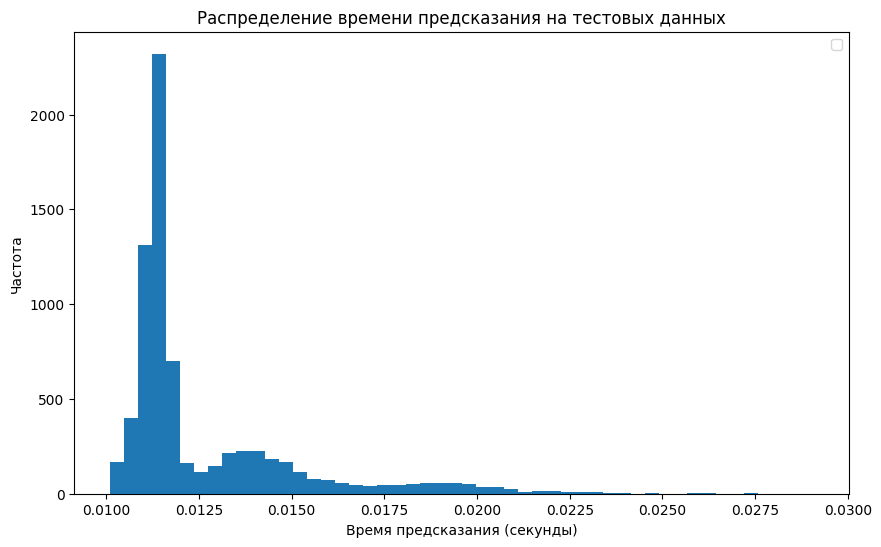

In [32]:
# Предсказание на тестовых данных
test_texts = test_df["text"].tolist()

print("Начинаем предсказание на тестовых данных...")
test_predictions = []
inference_times = []

for text in tqdm(test_texts):
    start_time = time.time()
    pred = predict(text)
    end_time = time.time()

    test_predictions.append(pred)
    inference_times.append(end_time - start_time)

# Добавляем предсказания в DataFrame
test_df['category'] = test_predictions

# Сохраняем результаты
test_df.to_csv('submission.csv', index=False)

# Анализ скорости
avg_inference_time = np.mean(inference_times)
max_inference_time = np.max(inference_times)

print(f"Среднее время предсказания на один пример: {avg_inference_time:.4f} секунд")
print(f"Максимальное время предсказания: {max_inference_time:.4f} секунд")
print(f"Соответствие ограничению по времени (5 сек): {'Да' if max_inference_time <= 5 else 'Нет'}")

# Визуализация распределения времени предсказания
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(inference_times, bins=50)
# plt.axvline(5, color='r', linestyle='--', label='Ограничение в 5 секунд')
plt.xlabel('Время предсказания (секунды)')
plt.ylabel('Частота')
plt.title('Распределение времени предсказания на тестовых данных')
plt.legend()
plt.show()

In [34]:
!zip -r /content/data.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.09.09/ (stored 0%)
  adding: content/.config/logs/2025.09.09/13.46.08.280393.log (deflated 58%)
  adding: content/.config/logs/2025.09.09/13.45.20.812567.log (deflated 92%)
  adding: content/.config/logs/2025.09.09/13.46.02.456374.log (deflated 86%)
  adding: content/.config/logs/2025.09.09/13.46.20.727375.log (deflated 57%)
  adding: content/.config/logs/2025.09.09/13.46.21.527799.log (deflated 56%)
  adding: content/.config/logs/2025.09.09/13.45.